**PHYS 139 Final Project:** attempting to recreate results from "Introducing the DREAMS Project: DaRk mattEr and Astrophysics with Machine Learning and Simulations" paper

**Goals:** to recreate the results from Section 4.2: "Inference with Convolutional Neural Networks"

In [1]:
## importing common packages
import numpy as np
import matplotlib.pyplot as plt
import scipy
import sys, os, time, optuna
import sklearn as sk

In [2]:
## defining global plotting parameters (can adjust as needed)

from matplotlib.colors import LogNorm
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import gridspec

plt.rcParams.update(plt.rcParamsDefault)  # Reset the default matplotlib settings

plt.rcParams['figure.figsize'] = (5, 4)  # Set the figure size (width, height) in inches

plt.rcParams['font.size'] = 12  # Set the font size for labels and titles
plt.rcParams['figure.dpi'] = 150  # Set the DPI (dots per inch) for high-resolution output
plt.rcParams['font.family'] = 'serif'  # Set the font family

plt.rcParams['axes.linewidth'] = 1.5  # Set the linewidth of the axes
plt.rcParams['axes.edgecolor'] = 'black'  # Set the color of the axes' edges
plt.rcParams['axes.spines.top'] = True  # Hide the top spine of the axes
plt.rcParams['axes.spines.right'] = True  # Hide the right spine of the axes

plt.rcParams['xtick.direction'] = 'in'  # Set the direction of x-axis ticks to inward
plt.rcParams['xtick.major.size'] = 4  # Set the size of major x-axis ticks
plt.rcParams['xtick.major.width'] = 1.2  # Set the width of major x-axis ticks
plt.rcParams['xtick.minor.size'] = 2  # Set the size of minor x-axis ticks
plt.rcParams['xtick.minor.width'] = 1.0  # Set the width of minor x-axis ticks

plt.rcParams['ytick.direction'] = 'in'  # Set the direction of y-axis ticks to inward
plt.rcParams['ytick.right'] = True  # Show the y-ticks on the right axis
plt.rcParams['ytick.major.size'] = 4  # Set the size of major y-axis ticks
plt.rcParams['ytick.major.width'] = 1.2  # Set the width of major y-axis ticks
plt.rcParams['ytick.minor.size'] = 2  # Set the size of minor y-axis ticks
plt.rcParams['ytick.minor.width'] = 1.0  # Set the width of minor y-axis ticks

plt.rcParams['lines.linewidth'] = 1.5  # Set the linewidth of the plotted lines
plt.rcParams['legend.frameon'] = False  # Hide the frame of the legend
plt.rcParams['legend.fontsize'] = 10  # Set the font size of the legend

## Loading in the images and playing around with them:
**Parameter Names and Meanings:**

* omegaM = matter density parameter, representing the fraction of the Universe's total energy density contributed by all matter. This is measured as a ratio of the Universe's mean matter density to the critical density (the density required to make the Universe spatially flat). Most measurements place the value at about 0.27. If omegaM > 1, the Universe has a closed geometry (will eventually collapse). If omegaM < 1, the Universe has an open geometry (will keep expanding forever). If omegaM = 1, the Universe has a perfectly flat geometry (expansion will slow but still never stop completely).

* sigma8 = cosmological constant that quantifies the amplitude of matter density fluctuations on a scale of 8 megaparsecs / (
Mpc). It is used to measure the "clumpiness" of the universe, representing how much matter has clustered together into structures like galaxies and galaxy clusters. Measurements from the early universe suggest a higher degree of clumpiness (a higher sigma8 value), while measurements of nearby galaxies and clusters indicate a lower level of clumpiness (a lower sigma8 value).

* SNe = parameter that controls the strength of supernova explosions in the TNG simulations. This has a major effect on gas density, dark matter density, etc, so it should be mentioned and included.

* SNv = parameter that controls the strength of supernova wind velocity in the TNG simulations. This also has a major effect on gas density, dark matter density, etc, so it should be mentioned and included

* AGN = parameter that controls the strength of active galactic nucleus (typically supermassive black hole) feedback in the TNG simulations. This also has a major effect on gas density, dark matter density, etc, so it should be mentioned and included.

* 1/m_WDM = 1 over the WDM particle mass, expressed often in keV or simply in this form.

In [3]:
raw_images = np.load('Images_Nbody_WDM_TNG_z=0.00.npy', mmap_mode = "r+")
print(raw_images.shape)

(15000, 256, 256)


In [4]:
## recreating the 3 plots in the "data_play_around" notebook:
fig, ax = plt.subplots(ncols = 3, nrows = 1, figsize = (10,3))

## plot 1:
bins = 20

WDM_params_test = np.loadtxt('WDM_TNG_params_1000.txt')
print(WDM_params_test.shape)
WDM_param_names = ['OmegaM','sigma8','SNE','SNv','AGN','1/m_WDM']
minimum = np.array([0.1,  0.6,  0.25,   0.5,    0.25, 0.0625])
maximum = np.array([0.5,  1.0,  4.00,   2.00,   4.00, 0.5555])
WDM_params_test = (WDM_params_test * (maximum - minimum)) + minimum
ax[0].hist((1./WDM_params_test[:, 5]), bins=bins, color='k', histtype='step', lw=3, density=False, log=False) # plot a histogram of the WDM masses, log scale histogram
ax[0].grid(True, ls='--', alpha=0.5, which='both')
ax[0].set_xlabel(r'$m_{\rm WDM}$ [keV]')

## plot 2:
ax[1].hist(WDM_params_test[:, 0], bins=10, color='k', histtype='step', lw=3, density=False, log=False)
ax[1].grid(True, ls='--', alpha=0.5, which='both')
ax[1].set_xlabel(r'$\Omega_{\rm M}$')

## plot 3:
epsilon = 0.005
OmegaM_range = [0.49-epsilon,0.49+epsilon]
sigma8_range = [0.8-4*epsilon,0.8+4*epsilon]
WDM_masses_test = (1./WDM_params_test[:, 5])[(WDM_params_test[:, 0] > OmegaM_range[0]) & (WDM_params_test[:, 0] < OmegaM_range[1]) & (WDM_params_test[:, 1] > sigma8_range[0]) & (WDM_params_test[:, 1] < sigma8_range[1])]

ax[2].hist(WDM_masses_test, bins=bins, color='k', histtype='step', lw=3, density=False, log=False)
ax[2].grid(True, ls='--', alpha=0.5, which='both')
ax[2].set_xlabel(r'$m_{\rm WDM}$ [keV]')

plt.show()

(1000, 6)


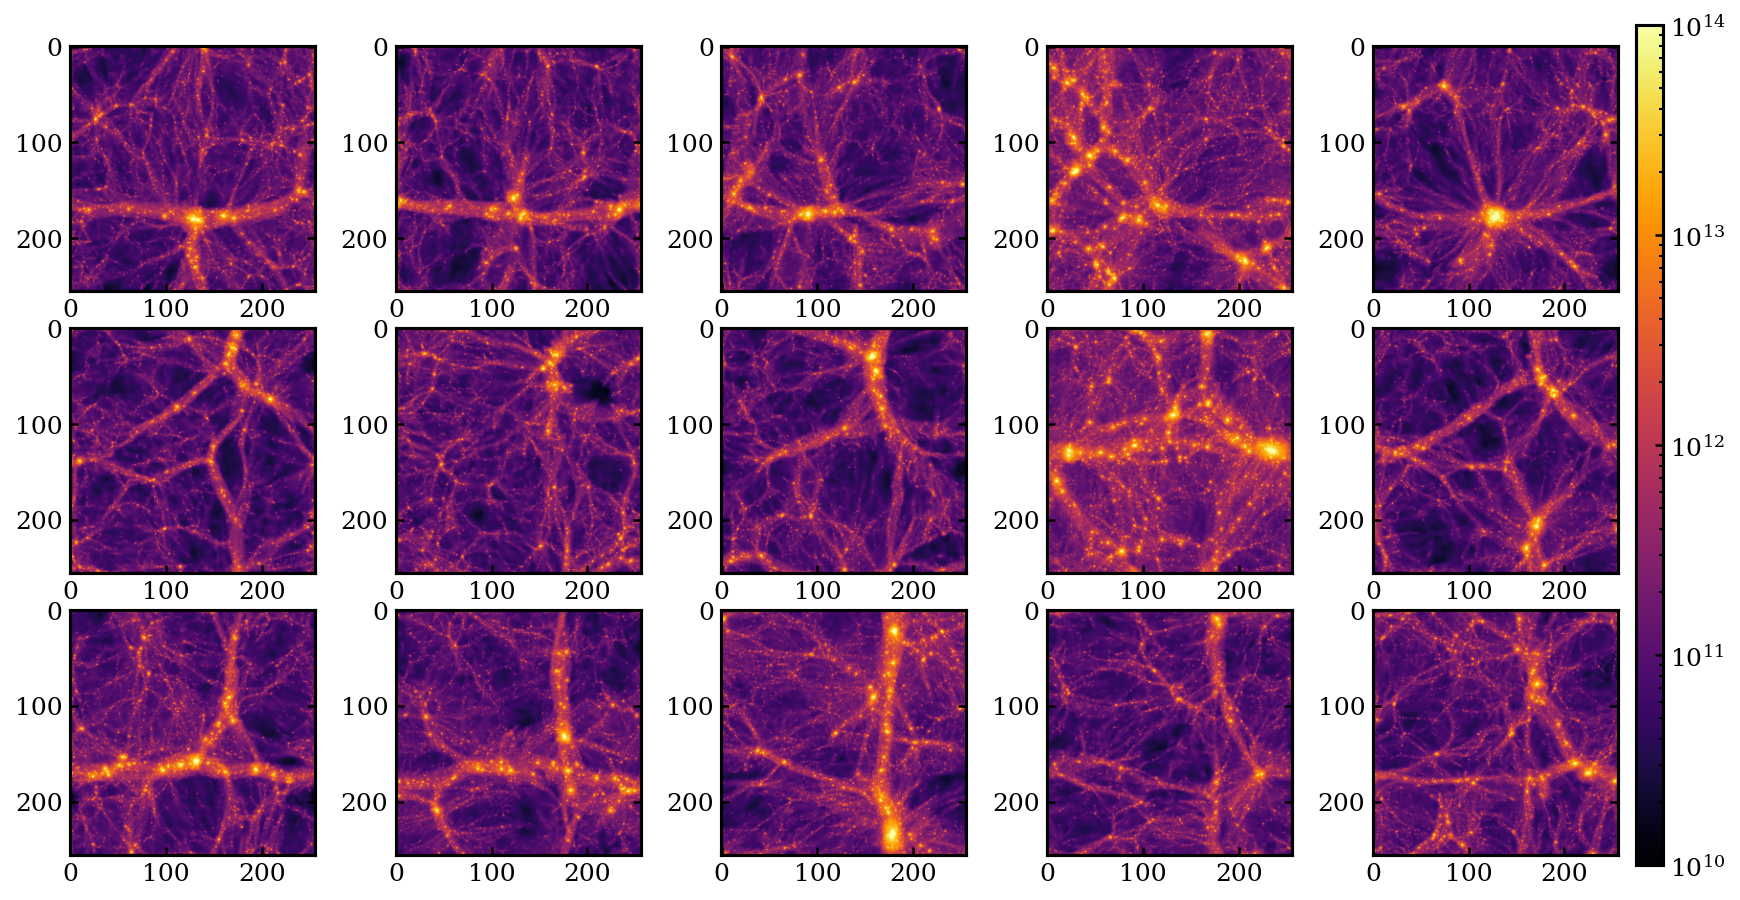

In [5]:
# visualise the first raw image, using log scale
mass_index = 5
epsilon = 0.005
omegam_mean = 0.49
sigma8_mean = 0.8
OmegaM_range = [omegam_mean-epsilon,omegam_mean+epsilon]
sigma8_range = [sigma8_mean-4*epsilon,sigma8_mean+4*epsilon]

valid_indices = ((WDM_params_test[:, 0] > OmegaM_range[0]) & (WDM_params_test[:, 0] < OmegaM_range[1]) & (WDM_params_test[:, 1] > sigma8_range[0]) & (WDM_params_test[:, 1] < sigma8_range[1]))

# finding the nth largest value in an array
index = np.argsort(WDM_params_test[:,mass_index])[-1]
error = 5e-1
target = 6 # keV
#index = np.where((WDM_params[:,mass_index] >= 1./(target + error)) & (WDM_params[:,mass_index] <= 1./(target - error)) & valid_indices)[0][0]
index = 0
#print(index)
vmin = 1e10; vmax = 1e14
#print(f'Params: {WDM_params[index]}')

## PLOT ONLY ONE PLOT:
#fig, axs = plt.subplots(figsize=(4,4), constrained_layout = True)
#print(f'WDM mass: {1./WDM_params[index][mass_index]} keV, OmegaM: {WDM_params[index][np.where(np.array(WDM_param_names) == "OmegaM")[0][0]]}, Sigma8: {WDM_params[index][np.where(np.array(WDM_param_names) == "sigma8")[0][0]]}')
#im = axs.imshow(raw_images[15*index + 3], norm=LogNorm(vmin=1e10, vmax=1e14), cmap='inferno')
#divider = make_axes_locatable(axs)
#cax = divider.append_axes("right", size="5%", pad=0.05)
#fig.colorbar(im, cax = cax)
#plt.show()

## LOOPING THROUGH FIRST 15 PLOTS:
fig, axes = plt.subplots(ncols = 5, nrows = 3, figsize=(14,7))
#plt.title(f'WDM mass: {1./WDM_params[index][mass_index]} eV')
for i, ax in enumerate(axes.flat):
    im = ax.imshow(raw_images[15*index + i], norm=LogNorm(vmin=vmin, vmax=vmax), cmap='inferno')

fig.subplots_adjust(wspace = 0.0025, hspace = 0.15)
cax = fig.add_axes([0.89, 0.1, 0.0125, 0.8])
fig.colorbar(im, cax=cax)
#plt.savefig("added_colorbar.png")
plt.show()

## Data Preprocessing:

RAW IMAGE DATA SHAPE: (15000, 256, 256)
ONLY FIRST IMAGE FROM EACH ARRAY ELEMENT SHAPE: (1000, 256, 256)


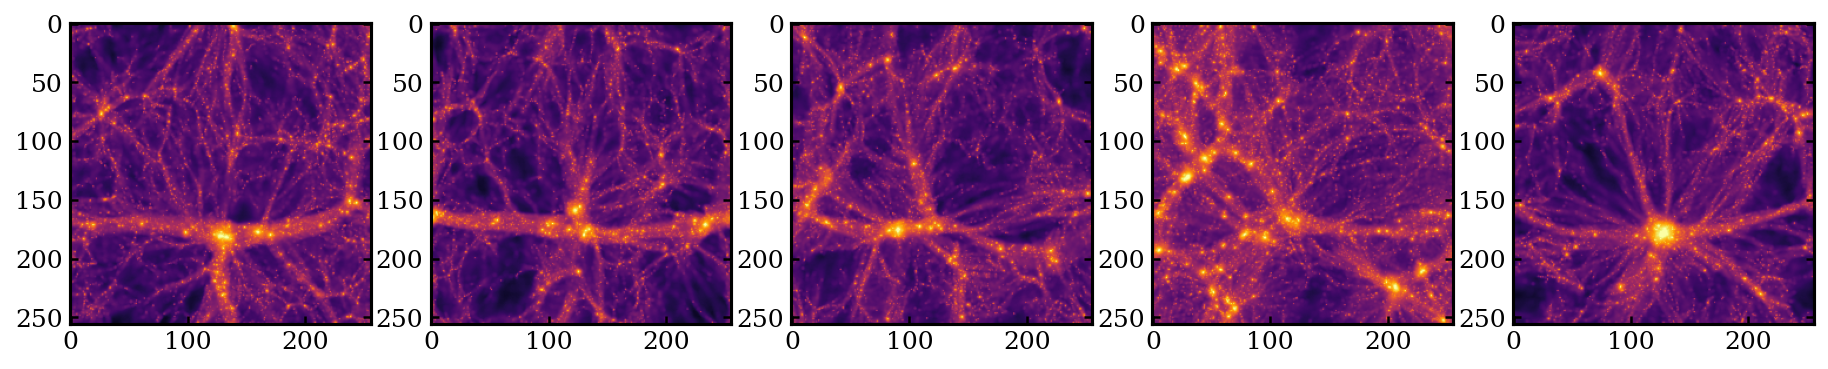

In [6]:
## data stored as 15,000 individual elements in a numpy array
## each simulation is stored as 15 slices along some axis
## for computation time, it would make sense to just take the (first?) image from each simulation
## let's make that dataset now:

raw_images = np.load('Images_Nbody_WDM_TNG_z=0.00.npy', mmap_mode = "r+")
print(f"RAW IMAGE DATA SHAPE: {raw_images.shape}")

counter = 0
only_first_raw_images = []
for img_index in range(0, len(raw_images), 15):
    only_first_raw_images.append(raw_images[counter])
    counter += 1

print(f"ONLY FIRST IMAGE FROM EACH ARRAY ELEMENT SHAPE: {np.array(only_first_raw_images).shape}")

    
## if we did this correctly, we should get the same row of images as in the previous step
fig, axes = plt.subplots(ncols = 5, nrows = 1, figsize = (15,3))
for i, ax in enumerate(axes.flat):
    im = ax.imshow(only_first_raw_images[i], norm = LogNorm(vmin = vmin, vmax = vmax), cmap = 'inferno')

#plt.savefig("test.png")
plt.show()

## problem fixed, had a bug w/ the counter
## now it works as intended

(1000, 256, 256)


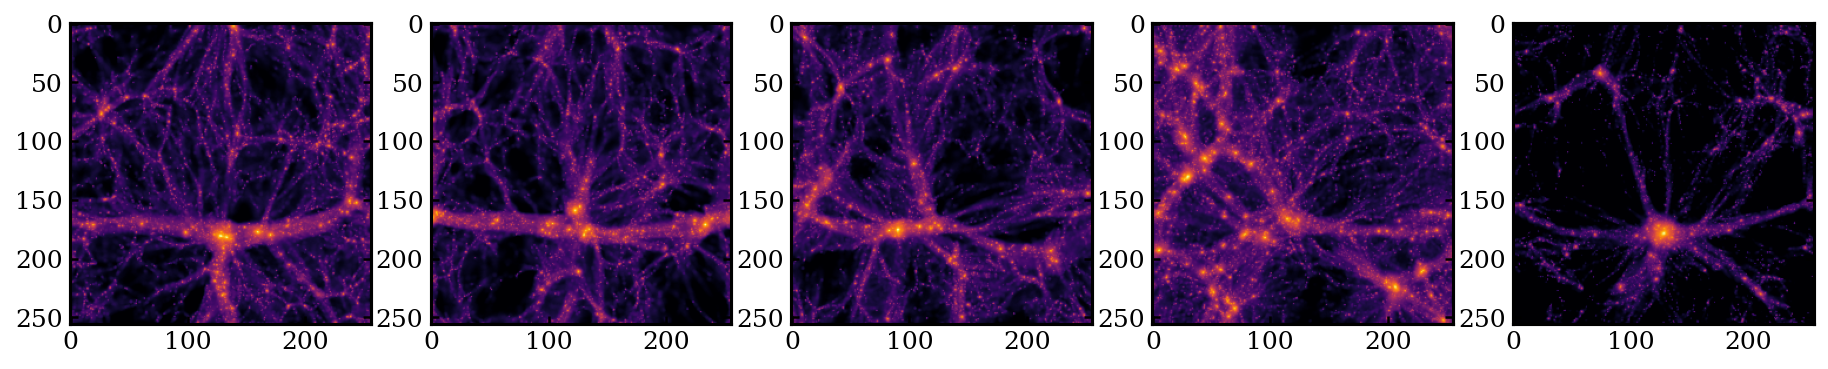

In [7]:
## more preprocessing:
## CNNs work better when the pixel values range from 0 to 1
## so we need to get the maximum pixel value across the entire image, then divide every pixel value by that maximum:

image_data = np.array(only_first_raw_images)
normalized_images = []

for index, img in enumerate(image_data):
    normalized_image = image_data[index] / np.max(image_data[index])
    normalized_images.append(normalized_image)

normalized_images_use = np.array(normalized_images)

print(normalized_images_use.shape)

## if we did this correctly, we should get the same row of images as in the previous step
fig, axes = plt.subplots(ncols = 5, nrows = 1, figsize = (15,3))
for i, ax in enumerate(axes.flat):
    im = ax.imshow(normalized_images_use[i], norm = LogNorm(vmin = 0.0001, vmax = 1), cmap = 'inferno')

#plt.savefig("test.png")
plt.show()

## Building the 2-D CNN:

**MODEL BUILDING HELP:** (Some info taken from PHYS139 lectures / GitHub.io page)

"There are four principal components to a CNN: a convolutional layer, a nonlinear activation function, a pooling or downsampling operation, and a fully connected layer for classification."
* Most TensorFlow models start with a Sequential layer, but you don't really need to do anything with this (besides name it if you want...)
* Conv2D --> takes in an integer for filters (first #), a "kernel" size (basically the size of the convolution window), a padding ("valid" = none or "same" = zero_padding), and (optional) activation function to use after convolution. "Once learned the kernels within the convolutional layer can appear as physically intuitive operations on the images such as edge detection filters."
* BatchNormalization --> tries to maintain the mean output close to 0 (stabilizes things)
* Activation --> "As with traditional neural networks, a nonlinear activation function is applied to the individual pixels in the resulting feature maps."
* MaxPooling2D --> "The pooling in the CNN downsamples or subsamples the feature maps. Pooling summarizes values within a region of interest (e.g., a pixel window). The summary can be the average pixel value but more commonly the maximum pixel value is preserved (max pooling) in the downsampling. This pooling of the feature maps reduces the size of the resulting network and makes the network less sensitive to small translations or distortions between images."

In [8]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

In [9]:
img_height, img_width = 256, 256

# get the total number of sims and maps:
splits = 15
WDM_params = np.loadtxt("WDM_TNG_params_1000.txt")  # simulations parameters, NOT maps parameters
total_sims, total_maps, num_params = WDM_params.shape[0], WDM_params.shape[0]*splits, WDM_params.shape[1]
params = np.zeros((total_maps, num_params), dtype = np.float32)
for i in range(total_sims):
    for j in range(splits):
        params[i * splits + j] = WDM_params[i]  # filling up the full params array for each individual image/map

print(f"Params Correct Shape if params.shape = (15000, 6) --> params.shape = {params.shape}")

Params Correct Shape if params.shape = (15000, 6) --> params.shape = (15000, 6)


In [10]:
# loading in parameters:
WDM_params = np.loadtxt('WDM_TNG_params_1000.txt')
print(WDM_params.shape)
WDM_param_names = ['OmegaM','sigma8','SNE','SNv','AGN','1/m_WDM']
minimum = np.array([0.1,  0.6,  0.25,   0.5,    0.25, 0.0625])
maximum = np.array([0.5,  1.0,  4.00,   2.00,   4.00, 0.5555])
WDM_params = (WDM_params * (maximum - minimum)) + minimum

(1000, 6)


In [11]:
import tensorflow as tf
import keras
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Activation, BatchNormalization, LeakyReLU, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

In [12]:
## TODO:
## do some rotations, flips, train on maybe all the slices??
## shuffle data, do k-fold validation
## L1/L2 regularization
## add dropout layers
## check batch normalization layers?
## different optimizer?
## adjust batch size

In [13]:
## using the hands-on portion from class for guidance:
def test_CNN(input_shape=(256, 256, 1), n_classes = 1):

    model = Sequential(name = "test_CNN")
    model.add(Input(shape = input_shape))

    ## conv. block 1:
    model.add(Conv2D(16, kernel_size = 3, strides = (1, 1), activation = "relu", padding = "valid", name = "conv_1_1"))
    model.add(Conv2D(16, kernel_size = 3, strides = (1, 1), activation = "relu", padding = "valid", name = "conv_1_2"))
    model.add(Conv2D(16, kernel_size = 2, strides = (1, 1), activation = "relu", padding = "same", name = "conv_1_3"))
    model.add(BatchNormalization(name = "bn_1_1"))
    model.add(BatchNormalization(name = "bn_1_2"))
    model.add(BatchNormalization(name = "bn_1_3"))
    model.add(MaxPooling2D(pool_size = (2,2), name = "pool_1"))
    model.add(Dropout(0.1, name = "dropout_1"))

    ## conv. block 2:
    model.add(Conv2D(4, kernel_size = 3, strides = (1, 1), activation = "relu", padding = "valid", name = "conv_2_1"))
    model.add(Conv2D(4, kernel_size = 3, strides = (1, 1), activation = "relu", padding = "valid", name = "conv_2_2"))
    model.add(Conv2D(4, kernel_size = 2, strides = (1, 1), activation = "relu", padding = "same", name = "conv_2_3"))
    model.add(BatchNormalization(name = "bn_2_1"))
    model.add(BatchNormalization(name = "bn_2_2"))
    model.add(BatchNormalization(name = "bn_2_3"))
    model.add(MaxPooling2D(pool_size = (2,2), name = "pool_2"))
    model.add(Dropout(0.1, name = "dropout_2"))
    
    #model.add(Activation("relu", name = "activation_1"))
    
    ## output layer
    activation = "sigmoid" if n_classes == 1 else "softmax"
    model.add(Flatten(name = "flatten_out"))
    model.add(Dense(n_classes, activation = activation, name = "fc_out"))
    
    return model

In [14]:
test_model = test_CNN()
test_model.summary()

Model: "test_CNN"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv_1_1 (Conv2D)                    │ (None, 254, 254, 16)        │             160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1_2 (Conv2D)                    │ (None, 252, 252, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_1_3 (Conv2D)                    │ (None, 252, 252, 16)        │           1,040 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn_1_1 (BatchNormalization)          │ (None, 252, 252, 16)        │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn_1_2 (BatchNormalization)          │ (None, 252, 252, 16)        │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn_1_3 (BatchNormalization)          │ (None, 252, 252, 16)        │              64 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_1 (MaxPooling2D)                │ (None, 126, 126, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 126, 126, 16)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2_1 (Conv2D)                    │ (None, 124, 124, 4)         │             580 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2_2 (Conv2D)                    │ (None, 122, 122, 4)         │             148 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv_2_3 (Conv2D)                    │ (None, 122, 122, 4)         │              68 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn_2_1 (BatchNormalization)          │ (None, 122, 122, 4)         │              16 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn_2_2 (BatchNormalization)          │ (None, 122, 122, 4)         │              16 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bn_2_3 (BatchNormalization)          │ (None, 122, 122, 4)         │              16 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ pool_2 (MaxPooling2D)                │ (None, 61, 61, 4)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 61, 61, 4)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_out (Flatten)                │ (None, 14884)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ fc_out (Dense)                       │ (None, 1)                   │          14,885 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 19,441 (75.94 KB)

 Trainable params: 19,321 (75.47 KB)

 Non-trainable params: 120 (480.00 B)

In [15]:
# training parameters:
batch_size = 128
learning_rate = 1e-9
epochs = 20
n_splits = 5

# use for preprocessing the same way as in the paper:
normalized_images_use_formatted = np.log10(normalized_images_use)
mean = np.mean(normalized_images_use_formatted)
std = np.std(normalized_images_use_formatted)
normalized_images_use_formatted = (normalized_images_use_formatted - mean) / std

X = normalized_images_use_formatted
y = WDM_params[:, 5]  # no knowledge of any of the other columns

kf = KFold(n_splits = n_splits, shuffle = True, random_state = 42)

fold_train_mse_results = []
fold_val_mse_results = []
trained_models = []

early_stopping_callbacks = [tf.keras.callbacks.EarlyStopping(monitor = 'val_mse', patience = 2, mode = 'max', restore_best_weights = True)]

for fold, (train_index, val_index) in enumerate(kf.split(X, y)):

    print(fold)

    # Split data into training and validation sets for the current fold
    X_train, X_val = X[train_index], X[val_index]
    y_train, y_val = y[train_index], y[val_index]

    optimizer = keras.optimizers.Adam(learning_rate = learning_rate)
    test_model.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['mse'])

    history = test_model.fit(X_train, y_train, epochs = epochs, batch_size = batch_size, verbose = 1,
                             validation_data = (X_val, y_val))

0
Epoch 1/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 38s 5s/step - loss: 1.0889 - mse: 0.0993 - val_loss: 0.7237 - val_mse: 0.0700
Epoch 2/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 32s 5s/step - loss: 1.0977 - mse: 0.1000 - val_loss: 0.7182 - val_mse: 0.0673
Epoch 3/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step - loss: 1.0864 - mse: 0.0955 - val_loss: 0.7133 - val_mse: 0.0648
Epoch 4/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step - loss: 1.1019 - mse: 0.1031 - val_loss: 0.7089 - val_mse: 0.0626
Epoch 5/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step - loss: 1.1193 - mse: 0.0991 - val_loss: 0.7050 - val_mse: 0.0607
Epoch 6/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 32s 4s/step - loss: 1.0909 - mse: 0.1015 - val_loss: 0.7014 - val_mse: 0.0589
Epoch 7/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 33s 5s/step - loss: 1.0636 - mse: 0.0972 - val_loss: 0.6981 - val_mse: 0.0573
Epoch 8/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 33s 5s/step - loss: 1.1127 - mse: 0.1036 - val_loss: 0.6953 - val_mse: 0.0558
Epoch 9/20
7/7 ━━━━━━━━━━━━━━━━━━━━ 35s 5s/step - loss: 1.0697 - mse: 0.0961 - val_los

In [16]:
train_loss = test_model.history.history['loss']
val_loss = test_model.history.history['val_loss']
train_mse = test_model.history.history['mse']
val_mse = test_model.history.history['mse']

plt.plot(train_loss, label = 'Training Loss')
plt.plot(val_loss, label = 'Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.savefig("training and validation loss")
plt.show()

In [18]:
y_pred = test_model.predict(X)

32/32 ━━━━━━━━━━━━━━━━━━━━ 6s 186ms/step


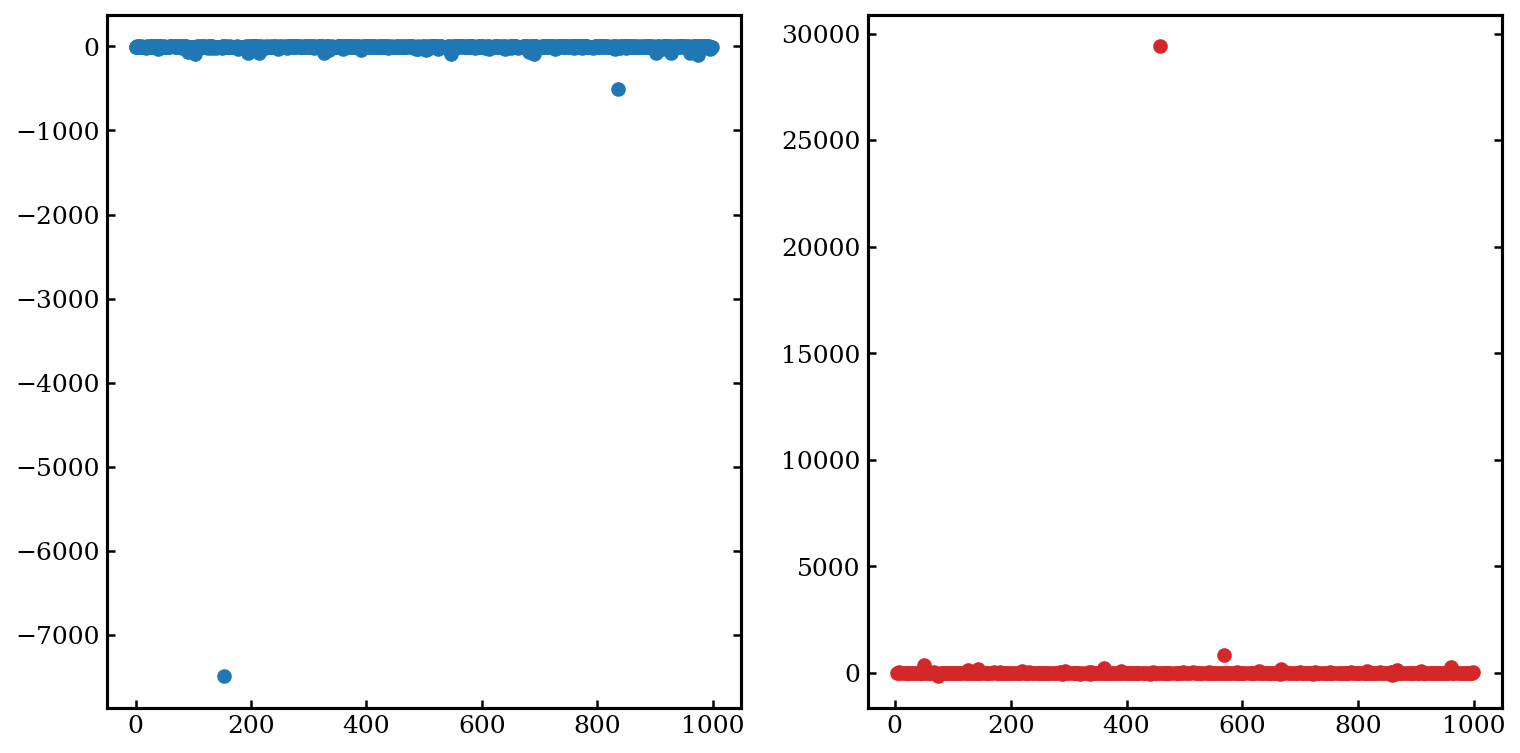

In [67]:
WDM_params_true = np.loadtxt('WDM_TNG_params_1000.txt')
inv_mass = WDM_params_true[:, 5]

fig, ax = plt.subplots(ncols = 2, nrows = 1, figsize = (12,6))

for index, model_pred in enumerate(y_pred):
    #print(index, model_pred[0], inv_mass[index], inv_mass[index] - model_pred[0])
    if 1/inv_mass[index] < 3.25:
        #print(f"True Value: {1/inv_mass[index]} keV, Model Prediction: {1/model_pred[0]} keV, Difference: {1/inv_mass[index] - 1/model_pred[0]}")
        ax[0].scatter(index, 1/inv_mass[index] - 1/model_pred[0], color = "tab:blue")
    elif 1/inv_mass[index] >= 3.25:
        ax[1].scatter(index, 1/inv_mass[index] - 1/model_pred[0], color = "tab:red")

#plt.savefig("true distributions.png")

In [66]:
fig, ax = plt.subplots(ncols = 2, nrows = 1, figsize = (10,5))

above_325 = (1/inv_mass)[np.where(1/inv_mass >= 3.25)]

above_325_Q1 = np.percentile(above_325, 0.25)
above_325_Q3 = np.quantile(above_325, 0.75)
above_325_IQR = above_325_Q3 - above_325_Q1
above_325_lower_bound = above_325_Q1 - 1.5 * above_325_IQR
above_325_upper_bound = above_325_Q3 + 1.5 * above_325_IQR

above_325_outliers = above_325[(above_325 < above_325_lower_bound) | (above_325 > above_325_upper_bound)]
above_325_filtered = above_325[(above_325 >= above_325_lower_bound) & (above_325 <= above_325_upper_bound)]
above_325_std = np.std(above_325_filtered)

plot_index = np.arange(0, len(above_325_filtered), 1)
ax[0].scatter(plot_index, above_325_filtered, color = "tab:blue")
ax[0].set_title(f"{(above_325_std):.2f}")
ax[0].set_ylim(0, 25)

below_325 = (1/inv_mass)[np.where(1/inv_mass < 3.25)]

below_325_Q1 = np.percentile(below_325, 0.25)
below_325_Q3 = np.quantile(below_325, 0.75)
below_325_IQR = above_325_Q3 - below_325_Q1
below_325_lower_bound = below_325_Q1 - 1.5 * below_325_IQR
below_325_upper_bound = below_325_Q3 + 1.5 * below_325_IQR

below_325_outliers = below_325[(below_325 < below_325_lower_bound) | (below_325 > below_325_upper_bound)]
below_325_filtered = below_325[(below_325 >= below_325_lower_bound) & (below_325 <= below_325_upper_bound)]

plot_index = np.arange(0, len(below_325_filtered), 1)
ax[1].scatter(plot_index, below_325_filtered, color = "tab:red")
ax[1].set_title(f"{(below_325_std):.2f}")
ax[1].set_ylim(0, 25)

above_325_std = np.std(above_325_filtered)
below_325_std = np.std(below_325_filtered)
print(above_325_std, below_325_std)

plt.savefig("standard deviations.png")

5.422461057107168 0.5899660473338142
